# Стратегия удержания клиентов в сети фитнес-центров

План проведения работы:

Шаг 1. [Загрузить данные](#step1)

Шаг 2. [Исследовательский анализ данных (EDA)](#step2)

Шаг 3. [Построить модель прогнозирования оттока клиентов](#step3)

Шаг 4. [Сделать кластеризацию клиентов](#step4)

Шаг 5. [Сформировать выводы и сделать базовые рекомендации по работе с клиентами](#step5)


### Шаг 1. Загрузить данные<a id="step1"></a>

In [1]:
#Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
#Прочитаем файл
gym_churn = pd.read_csv('gym_churn.csv', sep = ',')

In [3]:
#Посмотрим первые 5 строк
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
#Посмотрим общую информацию
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
#Проверим таблицу на дубликаты
gym_churn.duplicated().sum()

0

### Вывод

Всего таблица содержит информацию о 4000 клиентах, которых характеризуют 14 признаков.

Все признаки - числовые. Пропусков в данных нет, дубликаты отсутствуют. Тип данных не соответствует признаку 'Month_to_end_contract'.

### Шаг 2. Исследовательский анализ данных (EDA)<a id="step2"></a>

In [6]:
#Приведем названия столбцов к нижнему регистру
gym_churn.columns = gym_churn.columns.str.lower()

In [7]:
#Заменим тип данных с вещественного на целое число
gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype('int')

In [8]:
#Посмотрим описательные статистики
gym_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [9]:
#Сгруппируем клиентов по группам (тех, кто ушел в отток и тех, кто остался). Посмотрим описательные статистики.
#Напишем цикл.
for column in gym_churn.columns:
    print(gym_churn.groupby('churn')[[column]].describe().T)

churn                   0            1
gender count  2939.000000  1061.000000
       mean      0.510037     0.510839
       std       0.499984     0.500118
       min       0.000000     0.000000
       25%       0.000000     0.000000
       50%       1.000000     1.000000
       75%       1.000000     1.000000
       max       1.000000     1.000000
churn                          0            1
near_location count  2939.000000  1061.000000
              mean      0.873086     0.768143
              std       0.332933     0.422217
              min       0.000000     0.000000
              25%       1.000000     1.000000
              50%       1.000000     1.000000
              75%       1.000000     1.000000
              max       1.000000     1.000000
churn                    0            1
partner count  2939.000000  1061.000000
        mean      0.534195     0.355325
        std       0.498914     0.478837
        min       0.000000     0.000000
        25%       0.000000     0.00

Для бинарных признаков построим столбчатые графики и графики распределения для остальных количественных признаков.

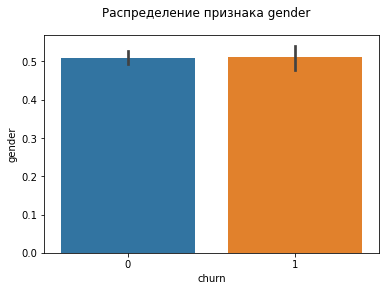

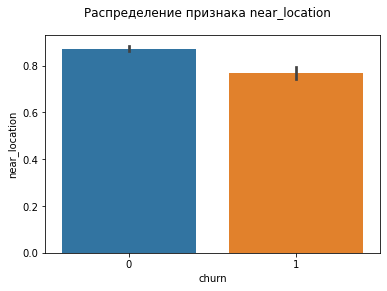

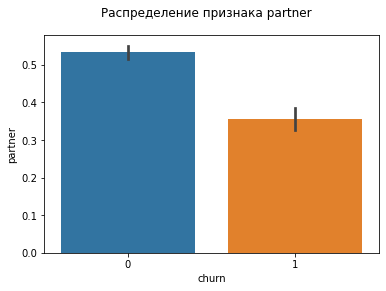

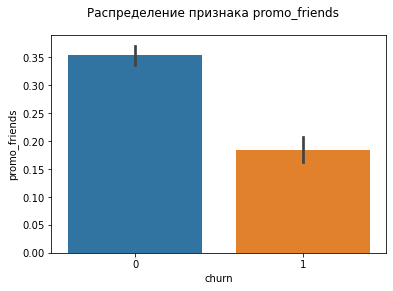

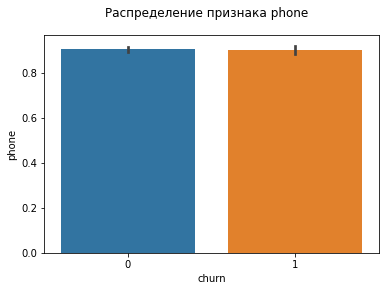

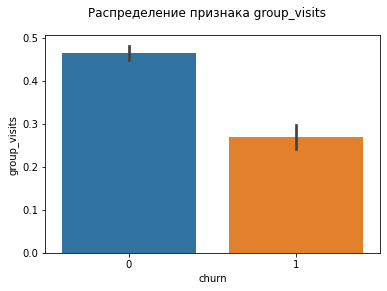

In [10]:
#Построим столбчатые графики распределения для бинарных признаков, напишем цикл
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    sns.barplot(data = gym_churn, x = 'churn', y = column)
    plt.suptitle('Распределение признака ' + column)
    plt.show()

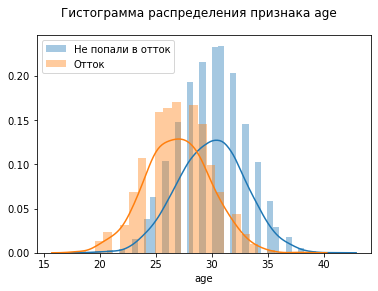

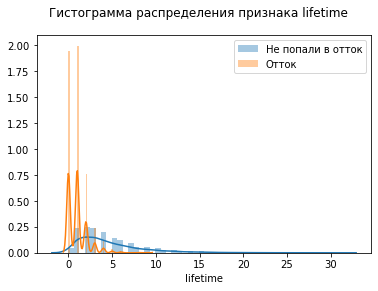

C:\Users\Maxim\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


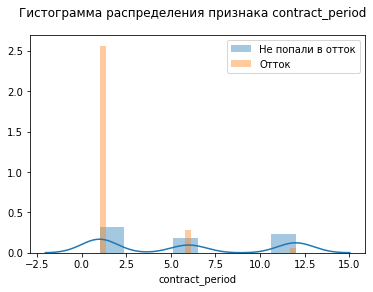

C:\Users\Maxim\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


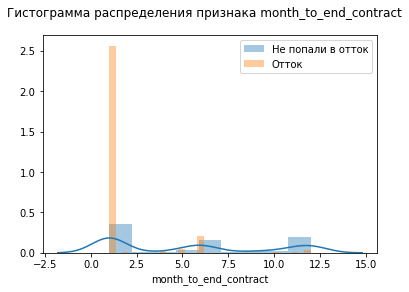

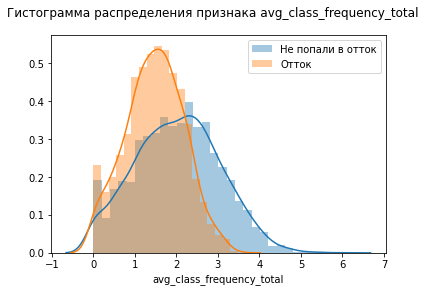

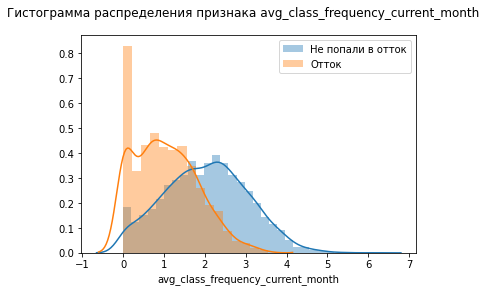

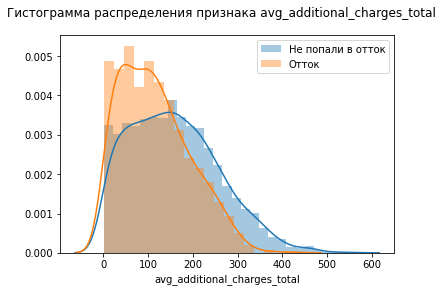

In [11]:
#Построим гистограммы распределения для количественных признаков в цикле
for column in [
    'age',
    'lifetime',
    'contract_period',
    'month_to_end_contract',
    'avg_class_frequency_total',
    'avg_class_frequency_current_month',
    'avg_additional_charges_total']:
    sns.distplot(gym_churn.query('churn == 0')[column])
    sns.distplot(gym_churn.query('churn == 1')[column])
    plt.legend(['Не попали в отток', 'Отток'])
    plt.suptitle('Гистограмма распределения признака ' + column)
    plt.show()

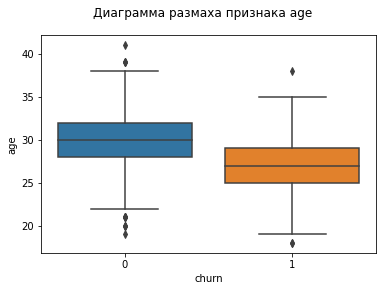

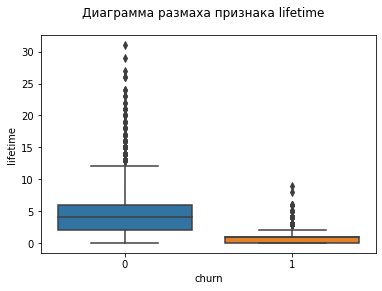

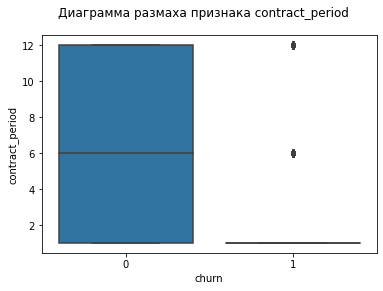

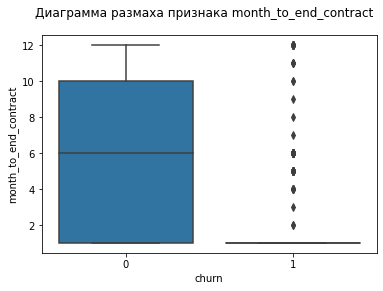

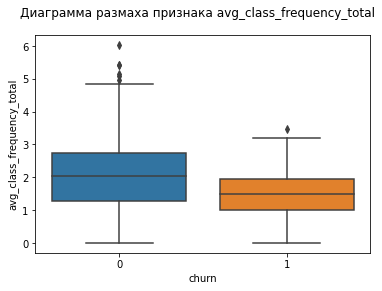

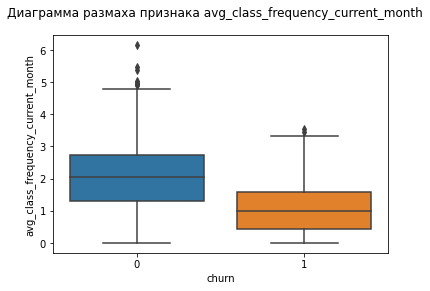

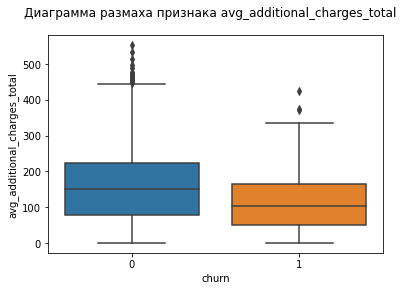

In [12]:
#Построим диаграмму размаха для количественных признаков в цикле
for column in [
    'age',
    'lifetime',
    'contract_period',
    'month_to_end_contract',
    'avg_class_frequency_total',
    'avg_class_frequency_current_month',
    'avg_additional_charges_total']:
    sns.boxplot(data = gym_churn, x = 'churn', y = column)
    plt.suptitle('Диаграмма размаха признака ' + column)
    plt.show()

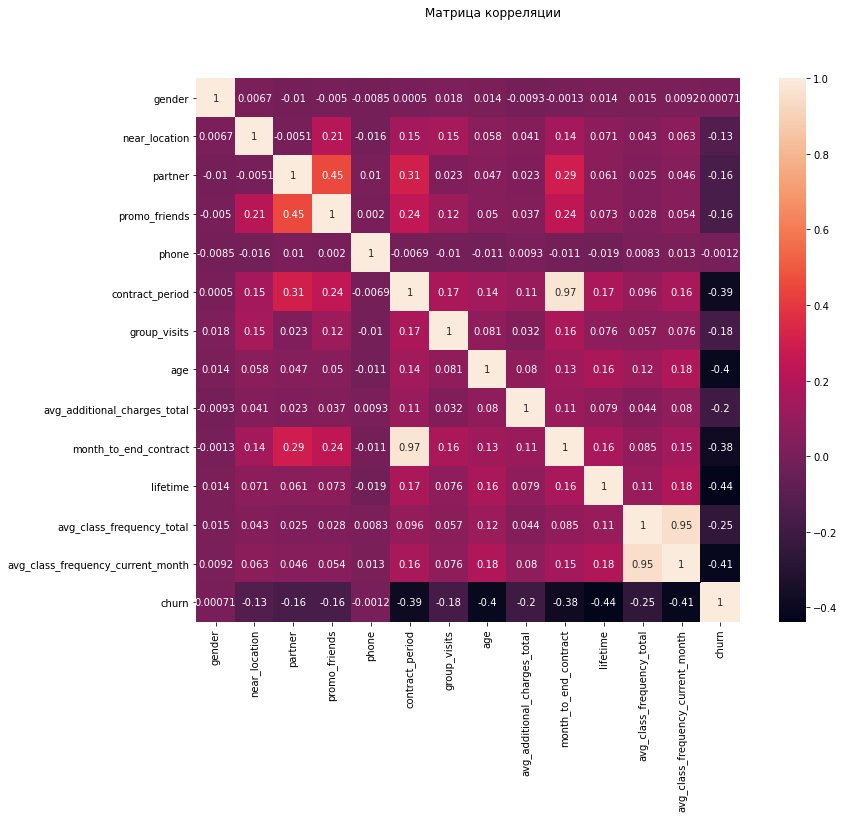

In [13]:
#Построим тепловую карту с подписями для матрицы корреляции
plt.figure(figsize=(14,10))
sns.heatmap(gym_churn.corr(), annot=True, square=True)
plt.suptitle('Матрица корреляции');

C:\Users\Maxim\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Maxim\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


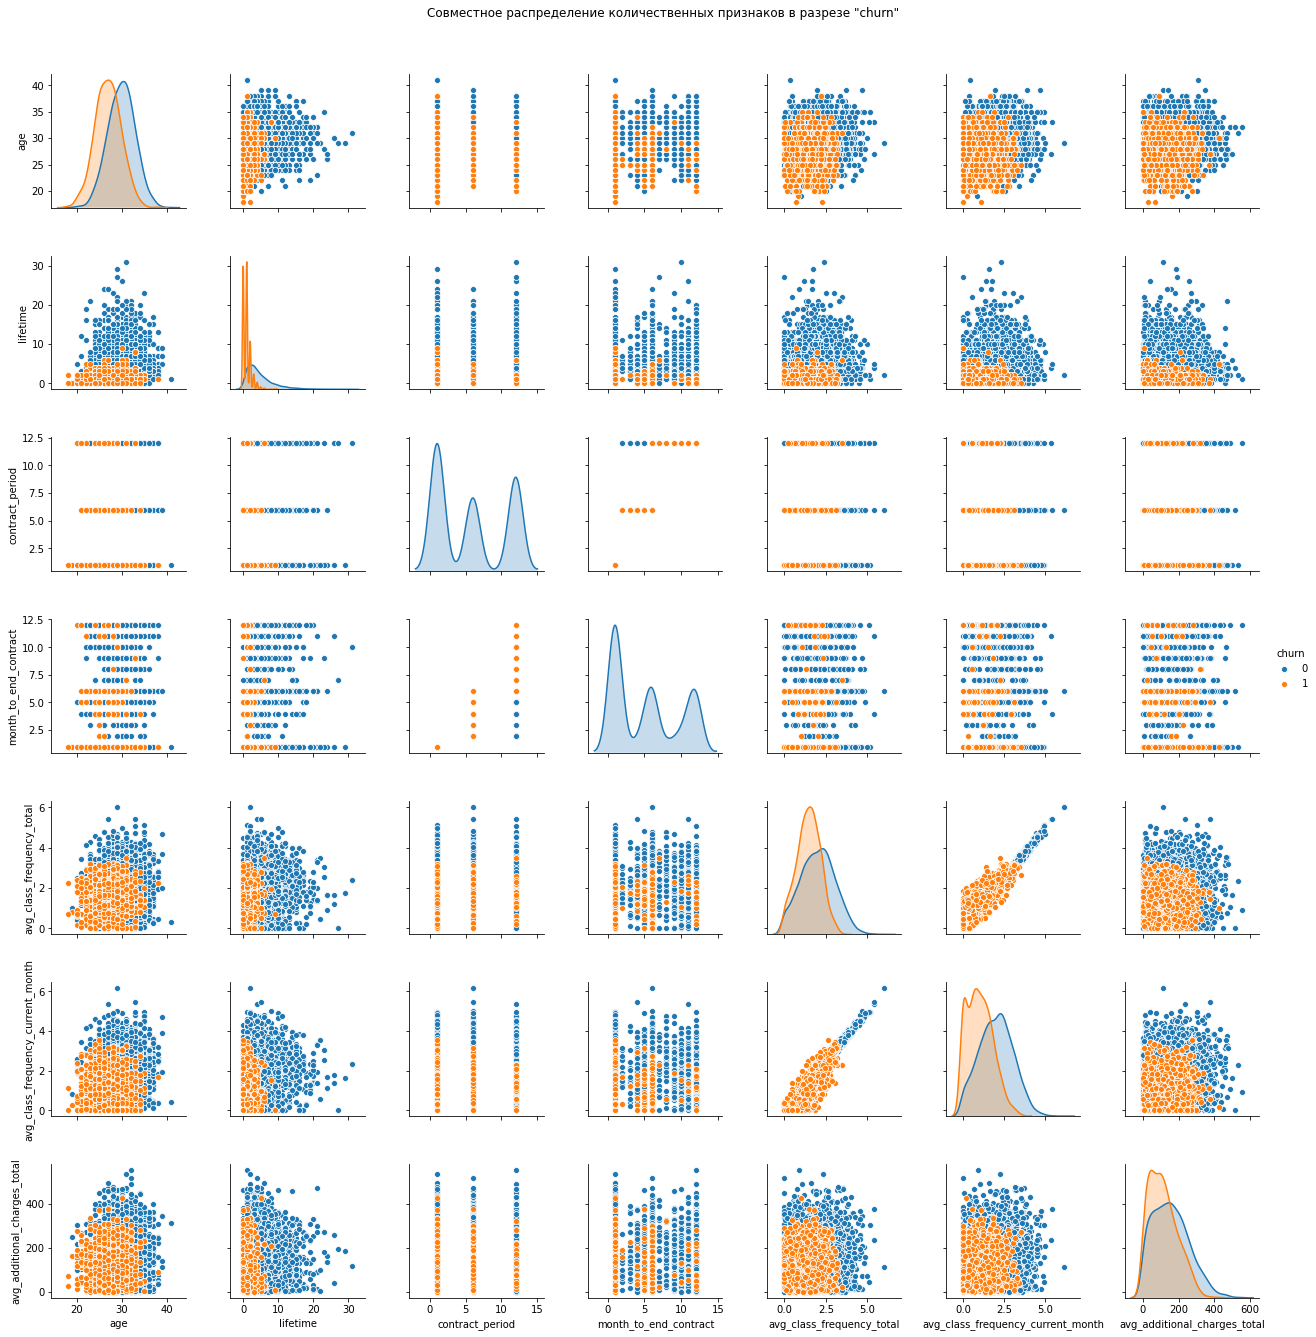

In [14]:
#Построим диаграммы совместного распределения количественных признаков
sns.pairplot(gym_churn[[
    'age',
    'lifetime',
    'contract_period',
    'month_to_end_contract',
    'avg_class_frequency_total',
    'avg_class_frequency_current_month',
    'avg_additional_charges_total',
    'churn'
]], hue = 'churn')
plt.suptitle('Совместное распределение количественных признаков в разрезе "churn"', y=1.05);

### Вывод

Клиенты практически в равной степени представлены мужчинами и женщинами, средний возраст составляет 29 лет. Чуть меньше половины клиентов являются сотрудниками компаний - партнёров клуба. Большинство клиентов проживает или работает рядом с фитнес-центром. Больше половины клиентов не посещают групповые занятия. В среднем время с момента первого обращения в фитнес-клуб составляет 3 месяца. Преимущественно клиенты посещают фитнес клуб 1-2 раза в неделю. Около 30% клиентов изначально записались в фитнес-клуб в рамках акции "приведи друга". При анализе описательных статистик признаков видно, что наибольшая разница между средним значением и медианой наблюдается по признакам: длительность текущего действующего абонемента, срок до окончания текущего действующего абонемента. Большой перекос наблюдается по этим признакам в сторону срока в 1 месяц. Самый большой разброс значений по признаку суммарной выручки от других услуг фитнес-центра. По матрице корреляции прослеживается зависимость между сотрудниками компаний-партнёров клуба, фактом первоначальной записи в рамках акции "приведи друга", сроком текущего действия/сроком до окончания абонемента и проживанием/работой в районе клуба.
Отток существующих клиентов на текущий месяц по сравнению с предыдущим составил 36,1%. Среди клиентов, которые попали в отток: на 18% меньше клиентов, которые являются сотрудниками компании-партнера клуба; на 10% меньше клиентов, которые живут или работают рядом с клубом; на 17% меньше клиентов, которые первоначально записались в клуб по акции "приведи друга"; на 20% меньше клиентов, которые посещают групповые занятия, - по сравнению с клиентами, которые не попали в отток. По этим признакам наблюдается отрицательная корреляция с признаком 'churn', но очень слабая.
Клиенты, которые попали в отток, моложе клиентов (в среднем 27 лет), которые продолжают посещать клуб (в среднем 30 лет). По диаграмме размаха и гистограмме так же видно, что клиенты из оттока гораздо моложе и в оттоке встречаются чаще клиенты, которым менее 22 лет и практически не встречаются клиенты, которым больше 35, за исключением выбросов. По матрице корреляции наблюдается слабая отрицательная зависимость между признаками 'age' и 'churn'.
Больше всего признак 'churn' коррелирует с 'lifetime', причем с отрицательным знаком. По графикам прослеживается зависимость между временем посещения клуба и оттоком клиентов, можно сказать: чем больше 'lifetime' тем меньше отток клиентов. Клиенты, которые посещают клуб более 2 месяцев практически не попадают в отток, за исключением выбросов. По графикам и по сильной корреляции между признаками 'contract_period' и 'month_to_end_contract' видно, что часто клиенты, которые купили абонемент на месяц, не возвращаются.
По графикам признаков 'avg_class_frequency_total' и 'avg_class_frequency_current_month' можно сказать, что клиенты, которые посещают в среднем фитнес-клуб реже чем 2 раза в неделю в текущем месяце наиболее часто попадают в отток на следующий месяц.
Клиенты, которые не попадают в отток на следующий месяц, обычно склонны тратить больше на дополнительные услуги фитнес-центра.

#### Шаг 3. Построить модель прогнозирования оттока клиентов<a id="step3"></a>

При построении матрицы корреляции признаков были обнаружены пары с высоким порогом корреляции: 'contract_period' и 'month_to_end_contract', 'avg_class_frequency_total' и 'avg_class_frequency_current_month'. Удалим по одному признаку из этих пар, чтобы избежать мультиколлинеарности.

In [15]:
#Убираем по одному признаку из каждой пары коррелирующих признаков
gym_churn.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1, inplace=True)

In [16]:
#Посмотрим на соотношение классов для набора данных
gym_churn['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

In [17]:
#Разделим данные на признаки (матрица Х) и целевую переменную (y)
X = gym_churn.drop('churn', axis = 1)
y = gym_churn['churn']

In [18]:
#Разделим модель на обучающую и валидационную выборку в отношении 80% к 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [19]:
#Обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [20]:
#Стандартизируем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [21]:
#Зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state = 0, solver='lbfgs')

In [22]:
#Обучим модель
lr_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0)

In [23]:
#Воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
#Бинарный прогноз
lr_predictions = lr_model.predict(X_test_st)

In [24]:
#Рассчитаем метрики для модели логистической регрессии
print(
    'Метрики для модели логистической регрессии',
    '\nAccuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)),
    '\nPrecision: {:.2f}'.format(precision_score(y_test, lr_predictions)),
    '\nRecall: {:.2f}'.format(recall_score(y_test, lr_predictions))
)

Метрики для модели логистической регрессии 
Accuracy: 0.92 
Precision: 0.85 
Recall: 0.84


In [25]:
#Зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

In [26]:
#Обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(random_state=0)

In [27]:
#Воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
#Бинарный прогноз
rf_predictions = rf_model.predict(X_test_st)

In [28]:
#Рассчитаем метрики для модели случайного леса
print(
    'Метрики для модели случайного леса',
    '\nAccuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)),
    '\nPrecision: {:.2f}'.format(precision_score(y_test, rf_predictions)),
    '\nRecall: {:.2f}'.format(recall_score(y_test, rf_predictions))
)

Метрики для модели случайного леса 
Accuracy: 0.91 
Precision: 0.85 
Recall: 0.77


Классы не сбалансированы. Для оценки качества классификатора посчитаем дополнительно метрику площади под кривой ошибок.

In [29]:
print(
    'ROC_AUC для логистической регрессии: {:.2f}'.format(roc_auc_score(y_test, lr_probabilities)),
    '\nROC_AUC для случайного леса: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities)),
)

ROC_AUC для логистической регрессии: 0.97 
ROC_AUC для случайного леса: 0.96


Оценим важность признаков для модели логистической регрессии.

In [30]:
#Обучим заново модель и сделаем прогноз
lr2_model = LogisticRegression(random_state = 0, solver='lbfgs')
lr2_model.fit(X_train, y_train)
lr2_predictions = lr_model.predict(X_test)

C:\Users\Maxim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
#Оценим важность признаков, построим таблицу с коэффициентами для каждого признака 
pd.DataFrame({'Feature': X.columns.tolist(),
'Coef': lr2_model.coef_.tolist()[0]})

,Feature,Coef
0,gender,0.243246
1,near_location,-0.576594
2,partner,0.602359
3,promo_friends,-0.562797
4,phone,1.142345
5,contract_period,-0.330121
6,group_visits,-0.303646
7,age,-0.296469
8,avg_additional_charges_total,-0.005774
9,lifetime,-1.029824


### Вывод

Для прогнозирования оттока пользователей были построены модели бинарной классификации клиентов на основе логистической регрессии и случайного леса.

Классы нашего набора данных не сбалансированы, поэтому оценивать модели по метрики Accuracy (доля правильных ответов) не совсем корректно, тем более что эта метрика по двум моделям отличается не существенно. Метрика Precision - точность (доля правильных ответов только среди целевого класса) составляет 85% сразу по обоим моделям. Метрика Recall - полнота показывает, что с помощью модели случайного леса можно обнаружить порядка 77% оттока клиентов, в тоже время модель логистической регрессии позволяет обнаружить 84% отток по клиентам. Для полноты картины была рассчитана метрика AUC-ROC, по ней модели опять-таки отличаются не существенно. Но если исходить из поставленных задач проекта и значений метрик, то прогнозировать отток клиентов лучше получается у модели логистической регрессии.

Для модели логистической регрессии были определены признаки, которые наиболее важны для неё, это в первую очередь: средняя частота посещений в неделю за предыдущий месяц, наличие контактного телефона, lifetime, проживание/работа в районе расположения фитнес-центра, факт первоначальной записи по акции "приведи друга" и сотрудничество с компаниями. Только признаки 'avg_class_frequency_current_month' и 'lifetime' из вышеперечисленного списка показывают наибольшую корреляцию с оттоком клиентов. Неожиданно высокий коэффициент у признака 'phone' и низкий у 'group_visits'. Можно сказать, то модель достаточно адекватная, но важность по некоторым признакам явно завышена, а по другим занижена.

### Шаг 4. Сделать кластеризацию клиентов<a id="step4"></a>

In [32]:
#Обучаем нормализатор и преобразуем набор данных: удалим столбец с оттоком клиентов
x_sc = scaler.fit_transform(gym_churn.drop(columns=['churn']))

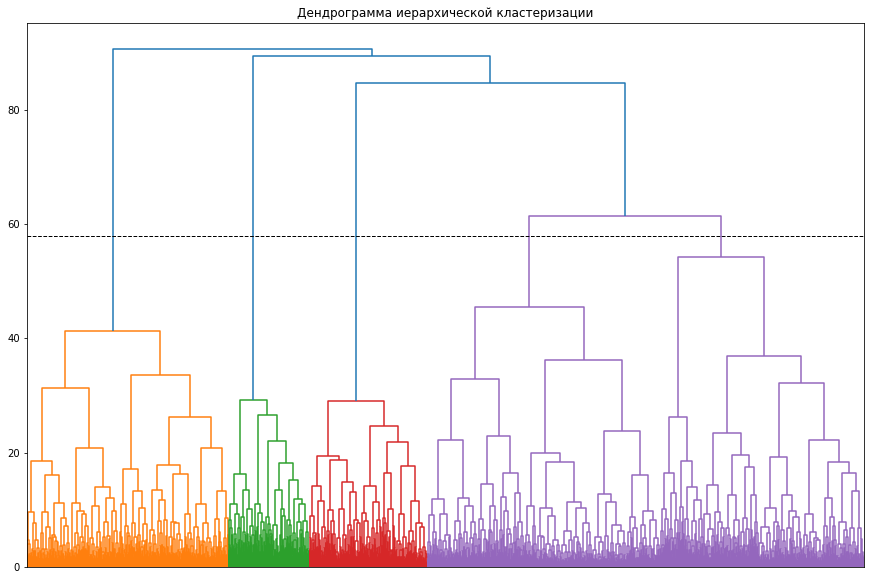

In [33]:
#Нарисуем дендрограмму, построим матрицу расстояний функцией linkage() на стандартизированной матрице признаков
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize = (15, 10))
dendrogram(linked, orientation = 'top', no_labels = True)
plt.axhline(y=58, c='black', lw=1, linestyle='dashed')
plt.title('Дендрограмма иерархической кластеризации')
plt.show()

После уровня 56 наблюдается увеличение расстояния между кластерами. Проведем линию на отметке 58, получается выделить 5 кластеров.

Воспользуемся теперь алгоритмом K-Means для кластеризации клиентов. Стандартизация данных уже была проведена ранее.

In [34]:
#Задаем число кластеров равное 5
km = KMeans(n_clusters = 5, random_state = 0)

In [35]:
#Применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(x_sc)

In [36]:
#Сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

In [37]:
#Выводим статистику по средним значениям наших признаков по кластеру
gym_churn.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,
0,0.490654,1.000000,0.217757,0.070093,1.0,2.047664,0.289720,27.673832,117.271746,1.935514,1.182898,0.558879
1,0.495943,0.995943,0.891481,1.000000,1.0,6.911765,0.523327,29.601420,153.355426,4.281947,1.919083,0.119675
2,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839
3,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
4,0.546000,0.996000,0.380000,0.011000,1.0,6.204000,0.528000,30.627000,178.905160,5.425000,2.353631,0.017000


In [38]:
#Посмотрим описательные статистики в разрезе кластеров
pd.options.display.max_columns = None
gym_churn.groupby('cluster_km').describe(include='all')

gender                                              near_location  \
             count      mean       std  min  25%  50%  75%  max         count   
cluster_km                                                                      
0           1070.0  0.490654  0.500146  0.0  0.0  0.0  1.0  1.0        1070.0   
1            986.0  0.495943  0.500237  0.0  0.0  0.0  1.0  1.0         986.0   
2            386.0  0.523316  0.500104  0.0  0.0  1.0  1.0  1.0         386.0   
3            558.0  0.500000  0.500449  0.0  0.0  0.5  1.0  1.0         558.0   
4           1000.0  0.546000  0.498129  0.0  0.0  1.0  1.0  1.0        1000.0   

                                                        partner            \
                mean       std  min  25%  50%  75%  max   count      mean   
cluster_km                                                                  
0           1.000000  0.000000  1.0  1.0  1.0  1.0  1.0  1070.0  0.217757   
1           0.995943  0.063596  0.0  1.0  1.0  1.0  1.0   986.0  0.891481   
2           0.862694  0.344616  0.0  1.0  1.0  1.0  1.0   386.0  0.471503   
3           0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   558.0  0.489247   
4           0.996000  0.063151  0.0  1.0  1.0  1.0  1.0  1000.0  0.380000   

                                              promo_friends            \
                 std  min  25%  50%  75%  max         count      mean   
cluster_km                                                              
0           0.412914  0.0  0.0  0.0  0.0  1.0        1070.0  0.070093   
1           0.311193  0.0  1.0  1.0  1.0  1.0         986.0  1.000000   
2           0.499835  0.0  0.0  0.0  1.0  1.0         386.0  0.305699   
3           0.500333  0.0  0.0  0.0  1.0  1.0         558.0  0.078853   
4           0.485629  0.0  0.0  0.0  1.0  1.0        1000.0  0.011000   

                                                phone                      \
                 std  min  25%  50%  75%  max   count mean  std  min  25%   
cluster_km                                                                  
0           0.255424  0.0  0.0  0.0  0.0  1.0  1070.0  1.0  0.0  1.0  1.0   
1           0.000000  1.0  1.0  1.0  1.0  1.0   986.0  1.0  0.0  1.0  1.0   
2           0.461301  0.0  0.0  0.0  1.0  1.0   386.0  0.0  0.0  0.0  0.0   
3           0.269751  0.0  0.0  0.0  0.0  1.0   558.0  1.0  0.0  1.0  1.0   
4           0.104355  0.0  0.0  0.0  0.0  1.0  1000.0  1.0  0.0  1.0  1.0   

                          contract_period                                     \
            50%  75%  max           count      mean       std  min  25%  50%   
cluster_km                                                                     
0           1.0  1.0  1.0          1070.0  2.047664  2.523337  1.0  1.0  1.0   
1           1.0  1.0  1.0           986.0  6.911765  4.726996  1.0  1.0  6.0   
2           0.0  0.0  0.0           386.0  4.777202  4.535814  1.0  1.0  1.0   
3           1.0  1.0  1.0           558.0  2.994624  3.505058  1.0  1.0  1.0   
4           1.0  1.0  1.0          1000.0  6.204000  4.794306  1.0  1.0  6.0   

                       group_visits                                          \
             75%   max        count      mean       std  min  25%  50%  75%   
cluster_km                                                                    
0            1.0  12.0       1070.0  0.289720  0.453844  0.0  0.0  0.0  1.0   
1           12.0  12.0        986.0  0.523327  0.499709  0.0  0.0  1.0  1.0   
2            6.0  12.0        386.0  0.427461  0.495352  0.0  0.0  0.0  1.0   
3            6.0  12.0        558.0  0.232975  0.423106  0.0  0.0  0.0  0.0   
4           12.0  12.0       1000.0  0.528000  0.499465  0.0  0.0  1.0  1.0   

                    age                                                     \
            max   count       mean       std   min   25%   50%   75%   max   
cluster_km                                                                   
0           1.0  1070.0  27.673832  

Построим графики, отражающие распределение каждого признака по выделенным кластерам.

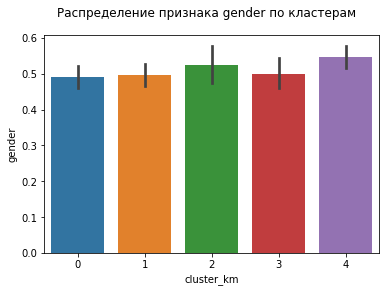

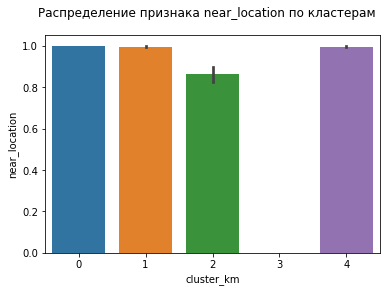

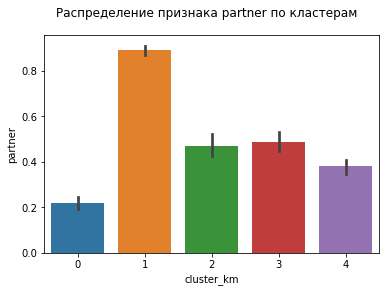

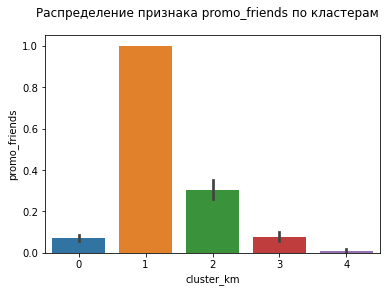

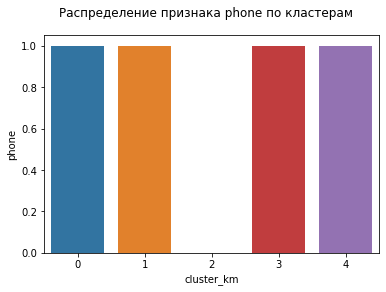

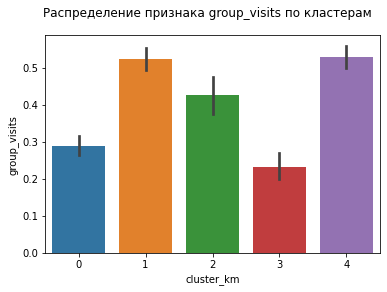

In [39]:
#Построим столбчатые графики распределения для бинарных признаков по кластерам, напишем цикл
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    sns.barplot(data = gym_churn, x = 'cluster_km', y = column)
    plt.suptitle('Распределение признака ' + column + ' по кластерам')
    plt.show()

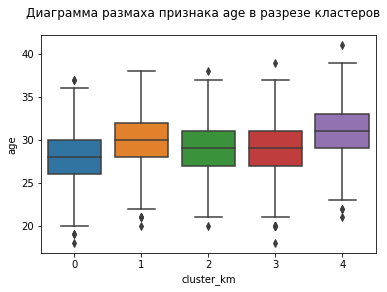

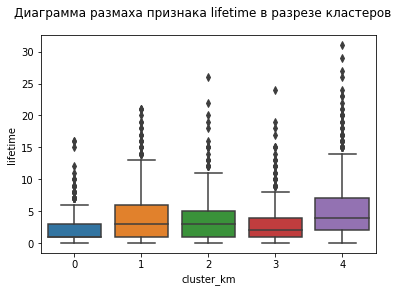

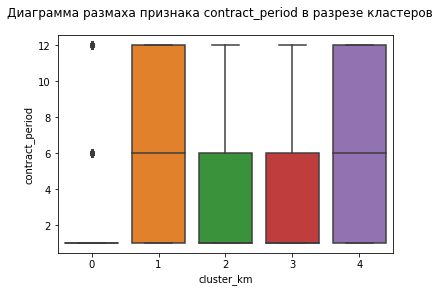

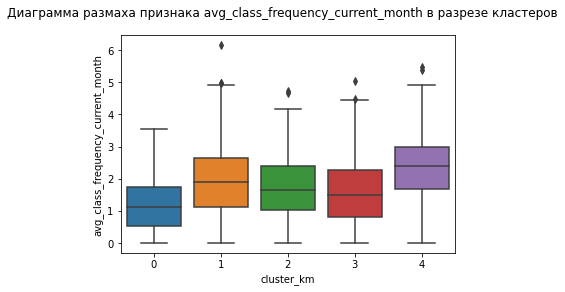

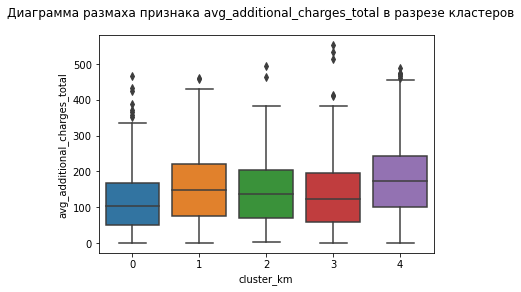

In [40]:
#Построим диаграмму размаха для количественных признаков в цикле в разрезе кластеров
for column in [
    'age',
    'lifetime',
    'contract_period',
    'avg_class_frequency_current_month',
    'avg_additional_charges_total']:
    sns.boxplot(data = gym_churn, x = 'cluster_km', y = column)
    plt.suptitle('Диаграмма размаха признака ' + column + ' в разрезе кластеров')
    plt.show()

In [41]:
#Посчитаем для каждого кластера долю оттока клиентов
cluster = gym_churn.groupby('cluster_km').agg({'churn': ['count', 'sum']})
cluster['share'] = ((cluster['churn']['sum'] / cluster['churn']['count']) * 100).round(1)
cluster.sort_values(by = 'share', ascending=False)

churn      share
           count  sum      
cluster_km                 
0           1070  598  55.9
3            558  225  40.3
2            386  103  26.7
1            986  118  12.0
4           1000   17   1.7

In [42]:
#Посчитаем метрику силуэта для нашей кластеризации
silhouette_score(x_sc, labels).round(2)

0.14

### Вывод

На основе дендрограммы выделяются 4 кластера, но по расстоянию можно выделить 5.
Для оценки разделения алгоритмом K-Means клиентов на кластеры была рассчитана метрика силуэта, которая показала низкий результат работы алгоритма. Можно сделать вывод, что для кластеров не присуща явная компактность и отделимость от других кластеров.

Охарактеризуем полученные кластеры:

0 - Клиенты этого кластера в основном работают/живут рядом с фитнес-клубом и являются сотрудниками компании-партнера клуба, записаны были в клуб по большой части в рамках акции "приведи друга", имеют в основном абонемент на 6 или 12 месяцев, посещают клуб более 3-4 месяцев и 2 раза в неделю (часто и до 5 раз), любят ходить на групповые занятия, часто пользуются дополнительными услугами клуба. Отток по этому кластеру один из самых низких среди всех кластеров - 12%. Клиенты кластера 0 составляют 25% от всех клиентов клуба. Можно предположить, что эти клиенты посещают клуб в рамках социального пакета, предоставленного их работодателем и не платят дополнительно за абонемент или платят только определенную часть, работают рядом с фитнес-клубом.

1 - Клиенты из 1 кластера как правило проживают/работают не рядом с местом нахождения фитнес-клуба, но практически  половина из них являются сотрудниками компании-партнера клуба, имеют в большинстве своем абонементы на 1 месяц или на 6 (на 6 месяцев реже), посещают клуб менее 3 месяцев и 1-2 раза в неделю, меньше всех посещают групповые занятия, в большинстве клиенты кластера 1 одни из самых молодых клиентов. Клиенты кластера 1 составляют 14% от всех клиентов клуба, их отток - 40,3%.

2 - Второй самый многочисленный: 26,6% от всех клиентов были отнесены к данному кластеру, но 56,4% клиентов кластера попадают в отток. Клиенты кластера самые молодые (в среднем им по 28 лет, так же наблюдаются выбросы по возрасту менее 21 года), всегда проживают/работают рядом с фитнес-центром, среди них мало тех, кто являются сотрудниками-партнера клуба, имеют абонементы на 1 месяц, посещают клуб в среднем 1-3 месяца и 1 раз в неделю (часто могут пропустить неделю),редко ходят на групповые занятия.

3 - Клиенты в основном работают/проживают рядом с фитнес-клубом, но в основном не являются сотрудниками компании-партнера клуба и записываются в клуб не в рамках акции "приведи друга", посещают клуб более 4-5 месяцев и в среднем 2-3 раза в неделю, имеют абонементы на 6-12 месяцев. По этому кластеру самая высокая посещаемость клуба и с момента записи, и по количеству раз в неделю, в том числе и по групповым занятиям.  Это самый возрастной кластер, в среднем возраст клиентов составляет 29-33 года. Клиенты этого кластера тратят обычно больше денег на дополнительные услуги, чем остальные клиенты. 25% клиентов были отнесены к этому кластеру и всего 1,5 % от этих клиентов попадают в отток. Можно сказать, что это в основном клиенты, которые проживают в непосредственной близости с фитнес-клубом.

4 - Четвертый кластер самый малочисленный - 9,65% от общей численности клиентов, отток составляет 26,7%. Особенность этой группы, что у всех клиентов группы отсутствует контактный телефон. В основном клиенты проживают/работают в районе фитнес-клуба, чуть меньше половины являются сотрудниками компании-партнера, многие обратились первый раз в клуб в рамках акции, имеют абонементы в среднем на 1 месяц (редко на 6 месяцев), посещают клуб в среднем 3 месяца, 1-2 раза в неделю, достаточно часто посещают групповые занятия. Выборка по 4 кластеру наименее репрезентативна по результатам и по численности по сравнению с остальными.

Наиболее подвережены оттоку оказались кластеры 2 и 1, самыми недёжными 3 и 0. 

### Шаг 5. Сформировать выводы и сделать базовые рекомендации по работе с клиентами<a id="step5"></a>

Клиенты фитнес-клуба в основном люди 22-37 лет, при этом клиенты в возрасте 27-33 в среднем тратят больше средств на дополнительные услуги клуба. Абонементы на 6-12 месяцев покупают в основном люди, которые работают или проживают рядом с фитнес-клубом. Люди, которые живут рядом или работают чаще всего посещают групповые занятия. Половина клиентов фитнес-клуба - это сотрудники компании-партнера клуба. В отток в основном попадают клиенты, которые покупают абонемент всего на месяц, проживают или работают не в районе нахождения фитнес-клуба, посещают фитнес-клуб реже 2 раз в неделю.

На основе кластеризации было выделено 5 кластеров, но среди них можно выделить 4 с наиболее характерными чертами:
- Клиенты, которые являются сотрудниками компании-партнера и работают в районе нахождения фитнес-клуба, с абонементами на 6-12 месяцев;
- Клиенты, которые живут в непосредственной близости от фитнес-клуба, часто посещают клуб и ходят на групповые занятия, с абонементами на 6-12 месяцев;
- Клиенты, которые проживают/работают не в районе расположения фитнес-клуба, посещают клуб 1-2 раза в неделю и купили абонемент на 1-6 месяцев;
- Клиенты, которые в основном купили абонемент на 1 месяц, как правило моложе остальных клиентов (средний возраст 28 лет), посещают клуб раз в неделю, живут/работают рядом с фитнес-клубом.

На основе анализа можно предложить следующие стратегии взаимодействия с клиентами чтобы избежать их оттока:

1. Клиентов стоит ориентировать на покупку абонемента на срок более 1 месяца, так как именно эти клиенты подвержены большому оттоку. Это может быть система скидок при покупке абонемента на более длительный срок, система рассрочки платежа. Для клиентов, которые живут рядом можно снизить цену и увеличить срок за счет абонемента, который будет действовать только в определенные часы, например, в дневное время.
2. Клиенты, которые посещают клуб менее 2 раз в неделю находятся в зоне риска. Можно при выявлении подобных клиентов предлагать персонализированные акции.
3. Клиентам, у которых подходит срок действия абонемента к концу так же стоит уделить внимание, допустим в виде дополнительных бонусов при покупке нового абонемента, к примеру: разовые бесплатные услуги фитнес-клуба или с хорошей скидкой, можно ввести накопительную систему поощрения-скидок зависящую от длительности посещения клуба.
4. Клиентам, моложе 28 лет свойственно чаще попадать в отток. Для них стоит следить за последними тенденциями и предлагать услуги "в тренде".